<a href="https://colab.research.google.com/github/Hrithik2212/-RNN-Sentimental-Analysis-on-Movie-Reviews---IMDB/blob/master/01_SelfLearningTicTacToe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Self Learning Tic-Tac-Toe Program

## Objective:
* 	To design a program that learns to play tic-tac-toe on its own
* 	The program is expected to learn by playing a large number of iterations of the game
* 	The program is not provided prior information about the game, the only information supplied to it is whether the game was won/lost/drawn

## Approach:

To break down the problem into simpler parts, let us define some terminologies.

**The self learning Program**:

The self learning program is the system that is expected to learn to play tic-tac-toe. It consists of the following components:
* 	**Legal Moves Generator:**
    * For a given board state, the Legal Moves Generator outputs the set of all possible legal next board states for a player
    
* 	**Evaluator (Neural Network Model):**
    * For a given board state, the evaluator predicts a score
    
*   **Program Move Selector:**
    * For a given board state, the Program Move Selector selects the next move for the Program using the following approach:
    
        *     Use the **Legal Moves Generator** to obtain the set of all possible legal next board states
        *     For each of the possible legal next board states above, use the **Evaluator** and predict a score
        *     The possible next board state with the highest predicted score is chosen for the next move
        


**Thus, the task of "learning" to play tic-tac-toe, can be reduced to the task of training the Evaluator to assign higher scores to board states favourable to the Program, and lower scores to board states that are unfavourable to the Program**

Below is a visual representation of the program:


![](https://image.ibb.co/dMXjKq/program-diagram-kaggle-v2.png)
   
   


**Training the Program**
*         The Program is trained by playing several iterations of games against a coded opponent
*         **The "Evaluator" mentioned above, is a neural network model**
*         During the first game, the neural network (Evaluator) is initialized with random weights
*         After the program plays the first game, the scores output by the neural network are corrected as follows:
    *         If the game was won by the program, assign the last board state a score of 1. Similarly, assign a score of -1 if the game was lost, and 0 if the game was drawn
    *         For each of the previous board states, assign the score that was predicted to the next board state
    *         For example, the second last board state is assigned the score that was predicted for the last board state, and so on
*         Update the weights of the neural network (using SGD) by fitting it to the board states and the corrected scores
*         Repeat the above process over and over, over a large number of games, updating the neural network after every game
*         The logic of the approach is that, for a player, if the final board state was a winning state, then the board states leading up to the final state would also be favourable
*         As the weight update process repeats over games, the neural network learns to assign a higher score to favourable board states, and lower scores to unfavourable board states
* Below is a diagram of the how the weights of the model would update after each game:


![](https://image.ibb.co/cf8oUq/training-kaggle-v3.png)
  
  
  








**Note:
This kernel is an implementation of chapter 1 of the  book [Machine Learning](http://www.cs.cmu.edu/afs/cs.cmu.edu/user/mitchell/ftp/mlbook.html)  by [Tom M Mitchell](http://www.cs.cmu.edu/~tom/). In the section "Design of a learning system", Mitchell describes the set up of a self learning checkers program. This is my attempt at trying to implement the approach for a tic-tac-toe game. I personally do not have much background in reinforcement learning, and if you find any issue in the kernel, please do let me know.**


### Table of contents
1.  Getting Started
2. Creating a Tic Tac Toe Game
3. Testing the Tic Tac Toe game
4. Creating the legal moves generator
5. Testing the legal moves generator
6. Creating the Evaluator (model)
7. Creating the Program Move Selector
8. Testing the Program Move Selector
9. Training the Program
10. A sample single training game
11. Training by playing a large number of games
12. Plotting the # Wins, Draws and Losses with respect to the number of games played above
13. Saving the model
14. Evaluating the Program
15. References




## Getting Started

In [ ]:
# Importing required moduless
import numpy as np
import pandas as pd
import pprint,random

from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


## Creating a Tic Tac Toe Game

In order for a program to learn how to play Tic-Tac-Toe, we first need to create the Tic-Tac-Toe game

Below, we create a simple tic tac toe game using Numpy

Below are the details of the Numpy Tic Tac Toe Game:
* The game board is a 3 * 3 numpy array
* The below is the denotation used:
    * 2: placeholder/empty cell
    * 0: 'O'
    * 1: 'X'
* By default, the array is filled with the number 2 as placeholder
* The number 0 denotes an 'O' and the number 1 denotes  an 'X'
* Players take turns in choosing the coordinates of the numpy array where they will place 0 or 1 respectively
* The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game
* For simplicity, the program always plays with the mark 1 and the opponent plays with 0

To get you used to the numpy tic tac toe board, below is a diagram
![](https://image.ibb.co/dDFa20/equivalent-kaggle.png)

In [ ]:
class tic_tac_toe_game(object):
    def __init__(self):
        self.board=np.full((3,3),2)

    def toss(self):
        """Function to simulate a toss and decide which player goes first

        Args:

        Returns:
        Returns 1 if player assigned mark 1 has won, or 0 if his opponent won

        """
        turn=np.random.randint(0,2,size=1)
        if turn.mean()==0:
            self.turn_monitor=0
        elif turn.mean()==1:
            self.turn_monitor=1
        return self.turn_monitor

    def move(self,player,coord):
        """Function to perform the action of placing a mark on the tic tac toe board
        After performing the action, this function flips the value of the turn_monitor to
        the next player

        Args:
        player: 1 if player who is assigned the mark 1 is performing the action,
        0 if his opponent is performing the action
        coord: The coordinate where the 1 or 0 is to be placed on the
        tic-tac-toe board (numpy array)

        Returns:
        game_status(): Calls the game status function and returns its value
        board: Returns the new board state after making the move

        """
        if self.board[coord]!=2 or self.game_status()!="In Progress" or self.turn_monitor!=player:
            raise ValueError("Invalid move")
        self.board[coord]=player
        self.turn_monitor=1-player
        return self.game_status(),self.board


    def game_status(self):
        """Function to check the current status of the game,
        whether the game has been won, drawn or is in progress

        Args:

        Returns:
        "Won" if the game has been won, "Drawn" if the
        game has been drawn, or "In Progress", if the game is still in progress

        """
        #check for a win along rows
        for i in range(self.board.shape[0]):
            if 2 not in self.board[i,:] and len(set(self.board[i,:]))==1:
                return "Won"
        #check for a win along columns
        for j in range(self.board.shape[1]):
            if 2 not in self.board[:,j] and len(set(self.board[:,j]))==1:
                return "Won"
        # check for a win along diagonals
        if 2 not in np.diag(self.board) and len(set(np.diag(self.board)))==1:
            return "Won"
        if 2 not in np.diag(np.fliplr(self.board)) and len(set(np.diag(np.fliplr(self.board))))==1:
            return "Won"
        # check for a Draw
        if not 2 in self.board:
            return "Drawn"
        else:
            return "In Progress"

### Testing the Tic Tac Toe game

To simply test the tic-tac-toe game created above, let us play a dummy game. We make the moves for both the players.

In [ ]:
# create an object of the class tick_tac_toe_game
game=tic_tac_toe_game()
# toss to decide which player goes first
game.toss()
print("Player ",game.turn_monitor," has won the toss")
# make the first move
print("Initial board state \n",game.board)
print("Let first player place their mark on 0,0")
game_status,board=game.move(game.turn_monitor,(0,0))
print("New Board State: \n",board)
print("Let second player place their mark on 0,1")
game_status,board=game.move(game.turn_monitor,(0,1))
print("New Board State: \n",board)
print("Let first player place their mark on 1,1")
game_status,board=game.move(game.turn_monitor,(1,1))
print("New Board State: \n",board)
print("Let second player place their mark on 0,2")
game_status,board=game.move(game.turn_monitor,(0,2))
print("New Board State: \n",board)
print("Let first player place their mark on 2,2")
game_status,board=game.move(game.turn_monitor,(2,2))
print("New Board State: \n",board)
print("Player ",1-game.turn_monitor," Has ",game_status)

Player  1  has won the toss
Initial board state 
 [[2 2 2]
 [2 2 2]
 [2 2 2]]
Let first player place their mark on 0,0
New Board State: 
 [[1 2 2]
 [2 2 2]
 [2 2 2]]
Let second player place their mark on 0,1
New Board State: 
 [[1 0 2]
 [2 2 2]
 [2 2 2]]
Let first player place their mark on 1,1
New Board State: 
 [[1 0 2]
 [2 1 2]
 [2 2 2]]
Let second player place their mark on 0,2
New Board State: 
 [[1 0 0]
 [2 1 2]
 [2 2 2]]
Let first player place their mark on 2,2
New Board State: 
 [[1 0 0]
 [2 1 2]
 [2 2 1]]
Player  1  Has  Won


## Creating the Legal Moves Generator

The legal moves genator accepts the board state and player as input, and provides the set of all possible legal moves as output.

Basically, for a given board state and player, it tells us where all the player can place his mark legally (the player can only place the mark where there is no opponent's mark)

In [ ]:
def legal_moves_generator(current_board_state,turn_monitor):
    """Function that returns the set of all possible legal moves and resulting board states,
    for a given input board state and player

    Args:
    current_board_state: The current board state
    turn_monitor: 1 if it's the player who places the mark 1's turn to play, 0 if its his opponent's turn

    Returns:
    legal_moves_dict: A dictionary of a list of possible next coordinate-resulting board state pairs
    The resulting board state is flattened to 1 d array

    """
    legal_moves_dict={}
    for i in range(current_board_state.shape[0]):
        for j in range(current_board_state.shape[1]):
            if current_board_state[i,j]==2:
                board_state_copy=current_board_state.copy()
                board_state_copy[i,j]=turn_monitor
                legal_moves_dict[(i,j)]=board_state_copy.flatten()
    return legal_moves_dict

### Testing the Legal Moves Generator

Let us test the above created Legal Moves Generator.

We start a dummy game, and do the toss. We then pass the current board state and toss winner to the Legal Moves Generator,

It returns the dictionary of legal moves that it returns

The dictionary is of the form "possible next legal move coordinate":"flattened resulting board state"

In [ ]:
game=tic_tac_toe_game()
game.toss()
print("Player ",game.turn_monitor," has won the toss")
print("Current board state \n",game.board)
legal_moves_dict=legal_moves_generator(game.board,game.turn_monitor)
print("Dictionary of Possible Next Legal Moves:")
pprint.pprint(legal_moves_dict)

Player  1  has won the toss
Current board state 
 [[2 2 2]
 [2 2 2]
 [2 2 2]]
Dictionary of Possible Next Legal Moves:
{(0, 0): array([1, 2, 2, 2, 2, 2, 2, 2, 2]),
 (0, 1): array([2, 1, 2, 2, 2, 2, 2, 2, 2]),
 (0, 2): array([2, 2, 1, 2, 2, 2, 2, 2, 2]),
 (1, 0): array([2, 2, 2, 1, 2, 2, 2, 2, 2]),
 (1, 1): array([2, 2, 2, 2, 1, 2, 2, 2, 2]),
 (1, 2): array([2, 2, 2, 2, 2, 1, 2, 2, 2]),
 (2, 0): array([2, 2, 2, 2, 2, 2, 1, 2, 2]),
 (2, 1): array([2, 2, 2, 2, 2, 2, 2, 1, 2]),
 (2, 2): array([2, 2, 2, 2, 2, 2, 2, 2, 1])}


You can observe above that the Legal Moves Generator returns a dictionary with all the possible legal coordinates and their resulting flattened numpy board states

## Creating the Evaluator (Neural Network Model)

As defined previously, the Evaluator function maps board states to scores.


![](https://i.ibb.co/MGbnKxd/evaluator.png)


It is expected that after training, the Evaluator learns to assign higher scores to board states that are favourable to the program.

In our kernel, we use a neural network as an Evaluator Function.

**Do note that, in the book Machine Learning by Tom M Mitchell, he describes using a linear model**. I used a neural network here. I plan on replacing this with a linear model to check if I can get similar results in future versions of the kernel.

Below, we create the neural network. The weights of the neural network are intialized randomly.

The architecture/hyperparameters of the neural network were picked through trial and error, and can be optimized further.

The neural network takes the flattened tic-tac-toe board numpy array as input and outputs a score.

In [ ]:
model = Sequential()
model.add(Dense(18, input_dim=9,kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(9, kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(9, kernel_initializer='normal',activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(5, kernel_initializer='normal',activation='relu'))
model.add(Dense(1,kernel_initializer='normal'))

learning_rate = 0.001
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum,nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                180       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 171       
_________________________________________________________________
dropout_2 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


## Creating the Program Move Selector

The Program Move Selector selects the next move for a player given the current board state using the following approach:
* Use the Legal Moves Generator to get all the possible next legal board states
* Use the Evaluator (model) to score each possible next board state
* The next board state that is assigned the highest score is selected as the next board state


![](https://image.ibb.co/dMXjKq/program-diagram-kaggle-v2.png)

In [ ]:
def move_selector(model,current_board_state,turn_monitor):
    """Function that selects the next move to make from a set of possible legal moves

    Args:
    model: The Evaluator function to use to evaluate each possible next board state
    turn_monitor: 1 if it's the player who places the mark 1's turn to play, 0 if its his opponent's turn

    Returns:
    selected_move: The numpy array coordinates where the player should place thier mark
    new_board_state: The flattened new board state resulting from performing above selected move
    score: The score that was assigned to the above selected_move by the Evaluator (model)

    """
    tracker={}
    legal_moves_dict=legal_moves_generator(current_board_state,turn_monitor)
    for legal_move_coord in legal_moves_dict:
        score=model.predict(legal_moves_dict[legal_move_coord].reshape(1,9))
        tracker[legal_move_coord]=score
    selected_move=max(tracker, key=tracker.get)
    new_board_state=legal_moves_dict[selected_move]
    score=tracker[selected_move]
    return selected_move,new_board_state,score

### Testing the Program Move Selector

Let us play a dummy game and use the above created Program Move Selector function to select the next move

In [ ]:
# new game
game=tic_tac_toe_game()
# toss
game.toss()
# choose the first move
print("Player assigned mark 1",game.turn_monitor," won the toss")
print("Initial board state:")
print(game.board)
selected_move,new_board_state,score=move_selector(model,game.board,game.turn_monitor)
print("Selected move: ",selected_move)
print("Resulting new board state: ",new_board_state)
print("Score assigned to above board state by Evaluator(model): ", score)

Player assigned mark 1 1  won the toss
Initial board state:
[[2 2 2]
 [2 2 2]
 [2 2 2]]
Selected move:  (0, 2)
Resulting new board state:  [2 2 1 2 2 2 2 2 2]
Score assigned to above board state by Evaluator(model):  [[0.00419072]]


Please note that since the Evaluator (model) has not yet been trained and has been assigned random weights, hence the score above is a random number

## Creating the opponent (The Opponent Move Selector)

For our program to self learn, it needs to play several games of tic-tac-toe.

But with who will it play with?

In the book "[Machine Learning](http://www.cs.cmu.edu/afs/cs.cmu.edu/user/mitchell/ftp/mlbook.html)", Mitchell describes the self learning checkers program learning by playing games against itself.

In older versions of this kernel, I did attempt to set it up so that the program was used to make the moves for both players.

However, the problem is that Tic-Tac-Toe is a simple game, and after about 10-15 games, I would always find that the program and the opponent program fell into a sync and played the same game (making the same moves) over and over, since they were using the same model.

Maybe this would work better for a more complex game like checkers.

Hence in this case, the set up is that the program learns by playing games against a coded opponent.

The opponent is coded to do the following:
* **If playing in "Easy" mode:**
    * When it is your turn, use the Legal Moves Generator to get all possible legal next moves
    * Pick a legal move at random
    * Repeat above until the end of the game
  
* **If playing in "Hard" mode:**
    * When it is your turn, use the Legal Moves Generator to get all possible legal next moves
    * Of the above legal moves, if any legal move makes you win (along row/column/diagonal), pick that legal move
    * Else, if any legal move prevents your opponent (program) from winning when it is one move away from a win, pick that move
    * Else, if any legal move leads to a row/diagonal/column having two 0's and no 1's (program's mark) , pick that legal move
    * If none of the above conditions exist, pick a legal move at random


The Program is trained by repeatedly playing games against the above opponent and updating the weights of the model at the end of each game.

Each game is played at either "Easy" or "Hard" mode, which is picked at random at the start of each game.

The "Easy" mode helps the Program explore the tic-tac-toe space. The "Hard" mode helps the Program learn how to play with a real opponent.

I arrived at the above approach for the opponent after different iterations in previous versions of this kernel , and can be further improved, I welcome suggestions with regards to that.

In [ ]:
def row_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan rowwise and identify coordinate amongst the legal coordinates that will
    result in a winning board state

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to win for the opponent
    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        #check for a win along rows
        for i in range(current_board_state_copy.shape[0]):
            if 2 not in current_board_state_copy[i,:] and len(set(current_board_state_copy[i,:]))==1:
                selected_move=legal_move_coord
                return selected_move

def column_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan column wise and identify coordinate amongst the legal coordinates that will
    result in a winning board state

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to win for the opponent
    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        for j in range(current_board_state_copy.shape[1]):
                    if 2 not in current_board_state_copy[:,j] and len(set(current_board_state_copy[:,j]))==1:
                        selected_move=legal_move_coord
                        return selected_move

def diag1_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan diagonal and identify coordinate amongst the legal coordinates that will
    result in a winning board state

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to win for the opponent

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 2 not in np.diag(current_board_state_copy) and len(set(np.diag(current_board_state_copy)))==1:
            selected_move=legal_move_coord
            return selected_move

def diag2_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan second diagonal and identify coordinate amongst the legal coordinates that will
    result in a winning board state

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to win for the opponent

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 2 not in np.diag(np.fliplr(current_board_state_copy)) and len(set(np.diag(np.fliplr(current_board_state_copy))))==1:
            selected_move=legal_move_coord
            return selected_move

#------------#

def row_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan rowwise and identify coordinate amongst the legal coordinates
    that will prevent the program
    from winning

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will block 1 from winning

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        for i in range(current_board_state_copy.shape[0]):
            if 2 not in current_board_state_copy[i,:] and (current_board_state_copy[i,:]==1).sum()==2:
                if not (2 not in current_board_state[i,:] and (current_board_state[i,:]==1).sum()==2):
                    selected_move=legal_move_coord
                    return selected_move

def column_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan column wise and identify coordinate amongst the legal coordinates that will prevent 1
    from winning

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will block 1 from winning

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor

        for j in range(current_board_state_copy.shape[1]):
                    if 2 not in current_board_state_copy[:,j] and (current_board_state_copy[:,j]==1).sum()==2:
                        if not (2 not in current_board_state[:,j] and (current_board_state[:,j]==1).sum()==2):
                            selected_move=legal_move_coord
                            return selected_move

def diag1_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan diagonal 1 and identify coordinate amongst the legal coordinates that will prevent 1
    from winning

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will block 1 from winning

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 2 not in np.diag(current_board_state_copy) and (np.diag(current_board_state_copy)==1).sum()==2:
                if not (2 not in np.diag(current_board_state) and (np.diag(current_board_state)==1).sum()==2):
                    selected_move=legal_move_coord
                    return selected_move

def diag2_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan second diagonal wise and identify coordinate amongst the legal coordinates that will
    result in a column having only 0s

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to two 0s being there (and no 1s)

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 2 not in np.diag(np.fliplr(current_board_state_copy)) and (np.diag(np.fliplr(current_board_state_copy))==1).sum()==2:
            if not (2 not in np.diag(np.fliplr(current_board_state)) and (np.diag(np.fliplr(current_board_state))==1).sum()==2):
                selected_move=legal_move_coord
                return selected_move

#---------------#
def row_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan rowwise and identify coordinate amongst the legal coordinates that will
    result in a row having two 0s and no 1s

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to two 0s being there (and no 1s)

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor

        for i in range(current_board_state_copy.shape[0]):
            if 1 not in current_board_state_copy[i,:] and (current_board_state_copy[i,:]==0).sum()==2:
                if not (1 not in current_board_state[i,:] and (current_board_state[i,:]==0).sum()==2):
                    selected_move=legal_move_coord
                    return selected_move

def column_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan column wise and identify coordinate amongst the legal coordinates that will
    result in a column having two 0s and no 1s

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to two 0s being there (and no 1s)

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor

        for j in range(current_board_state_copy.shape[1]):
                    if 1 not in current_board_state_copy[:,j] and (current_board_state_copy[:,j]==0).sum()==2:
                        if not (1 not in current_board_state[:,j] and (current_board_state[:,j]==0).sum()==2):
                            selected_move=legal_move_coord
                            return selected_move

def diag1_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan diagonal wise and identify coordinate amongst the legal coordinates that will
    result in a column having two 0s and no 1s

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to two 0s being there (and no 1s)

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 1 not in np.diag(current_board_state_copy) and (np.diag(current_board_state_copy)==0).sum()==2:
            if not (1 not in np.diag(current_board_state) and (np.diag(current_board_state)==0).sum()==2):
                selected_move=legal_move_coord
                return selected_move

def diag2_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    """Function to scan second diagonal wise and identify coordinate amongst
    the legal coordinates that will result in a column having two 0s and no 1s

    Args:
    legal_moves_dict: Dictionary of legal next moves
    turn_monitor: whose turn it is to move

    Returns:
    selected_move: The coordinates of numpy array where opponent places their mark

    """
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 1 not in np.diag(np.fliplr(current_board_state_copy)) and (np.diag(np.fliplr(current_board_state_copy))==0).sum()==2:
            if not (1 not in np.diag(np.fliplr(current_board_state)) and (np.diag(np.fliplr(current_board_state))==0).sum()==2):
                selected_move=legal_move_coord
                return selected_move

def opponent_move_selector(current_board_state,turn_monitor,mode):
    """Function that picks a legal move for the opponent

    Args:
    current_board_state: Current board state
    turn_monitor: whose turn it is to move
    mode: whether hard or easy mode

    Returns:
    selected_move: The coordinates of numpy array where placing the 0 will lead to two 0s being there (and no 1s)

    """
    legal_moves_dict=legal_moves_generator(current_board_state,turn_monitor)

    winning_move_checks=[row_winning_move_check,column_winning_move_check,diag1_winning_move_check,diag2_winning_move_check]
    block_move_checks=[row_block_move_check,column_block_move_check,diag1_block_move_check,diag2_block_move_check]
    second_move_checks=[row_second_move_check,column_second_move_check,diag1_second_move_check,diag2_second_move_check]

    if mode=="Hard":
        random.shuffle(winning_move_checks)
        random.shuffle(block_move_checks)
        random.shuffle(second_move_checks)

        for fn in winning_move_checks:
            if fn(current_board_state,legal_moves_dict,turn_monitor):
                return fn(current_board_state,legal_moves_dict,turn_monitor)

        for fn in block_move_checks:
            if fn(current_board_state,legal_moves_dict,turn_monitor):
                return fn(current_board_state,legal_moves_dict,turn_monitor)

        for fn in second_move_checks:
            if fn(current_board_state,legal_moves_dict,turn_monitor):
                return fn(current_board_state,legal_moves_dict,turn_monitor)

        selected_move=random.choice(list(legal_moves_dict.keys()))
        return selected_move

    elif mode=="Easy":
        legal_moves_dict=legal_moves_generator(current_board_state,turn_monitor)
        selected_move=random.choice(list(legal_moves_dict.keys()))
        return selected_move

## Training the Program

Training the progam is essentially training the Evaluator(model) to assign higher scores to board states favourable to the program, and lower scores to board states unfavourable to the program.

The progam is expected to learn by playing games against the Opponent.

The Evaluator (model) is trained in the following way:
* At first the weights of the model are randomly assigned
* Using this model, the Move Selector function selects the next move to make for the program
* The program and the opponent make thier moves until the game ends
* After the game is completed, the scores are corrected as follows:
    * If the game was Won by the program, assign the score 1 to the final board state, or assign -1 if lost or 0 if drawn
    * Shift the remaining scores so that they become the scores of the previous board states
    * Update the weights of the model using the board state and corrected score
* The above process is repeated over 100s of thousands of games
* It is expected that eventually, the Evaluator (model) learns to assign higher scores to more favourable board states and lower scores to less favourable board states



![](https://image.ibb.co/cf8oUq/training-kaggle-v3.png)



#### An intuitive explanation of the above logic:
An intuitive explanation of the above logic:

https://cs.stackexchange.com/questions/3296/why-does-the-experience-propagation-rule-for-checkers-work-in-tom-mitchells-boo

* Remember that the only information provided to the model is whether the game was won, lost or drawn
* If a game was won by the Program, it means that the final board state was a winning board state. Furthermore, it means that the second last board state, which was only 1 move away from winning, was a very favourable board state for the Program. The same goes for the third last, fourth last and so on
* At the end of each game, depending on whether the Progam won/lost/drawn, the score for the final board state is corrected by setting it to 1 or -1 or 0 respectively. The scores for the other board states are corrected by assigning the score predicted for the successor board state. The model weights are then updated by fitting it to the board state and corrected score
* Over several iterations of the games, as the experience propogrates backwards, it is expected that the model learns to predict higher scores board states favourable to the Program, and lower scores to board states unfavourable to the Program


My understanding is that the approach above is called temporal difference learning.

Mitchell states in his book that this approach has been found to be surprisingly effective for the checkers player, and has been known to converge to the target function well.

In [ ]:
def train(model,mode,print_progress=False):
    """Function trains the Evaluator (model) by playing a game against an opponent
    playing random moves, and updates the weights of the model after the game

    Note that the model weights are updated using SGD with a batch size of 1

    Args:
    model: The Evaluator function being trained

    Returns:
    model: The model updated using SGD
    y: The corrected scores

    """
    # start the game
    if print_progress==True:
        print("___________________________________________________________________")
        print("Starting a new game")
    game=tic_tac_toe_game()
    game.toss()
    scores_list=[]
    corrected_scores_list=[]
    new_board_states_list=[]

    while(1):
        if game.game_status()=="In Progress" and game.turn_monitor==1:
            # If its the program's turn, use the Move Selector function to select the next move
            selected_move,new_board_state,score=move_selector(model,game.board,game.turn_monitor)
            scores_list.append(score[0][0])
            new_board_states_list.append(new_board_state)
            # Make the next move
            game_status,board=game.move(game.turn_monitor,selected_move)
            if print_progress==True:
                print("Program's Move")
                print(board)
                print("\n")
        elif game.game_status()=="In Progress" and game.turn_monitor==0:
            selected_move=opponent_move_selector(game.board,game.turn_monitor,mode=mode)

            # Make the next move
            game_status,board=game.move(game.turn_monitor,selected_move)
            if print_progress==True:
                print("Opponent's Move")
                print(board)
                print("\n")
        else:
            break


    # Correct the scores, assigning 1/0/-1 to the winning/drawn/losing final board state,
    # and assigning the other previous board states the score of their next board state
    new_board_states_list=tuple(new_board_states_list)
    new_board_states_list=np.vstack(new_board_states_list)
    if game_status=="Won" and (1-game.turn_monitor)==1:
        corrected_scores_list=shift(scores_list,-1,cval=1.0)
        result="Won"
    if game_status=="Won" and (1-game.turn_monitor)!=1:
        corrected_scores_list=shift(scores_list,-1,cval=-1.0)
        result="Lost"
    if game_status=="Drawn":
        corrected_scores_list=shift(scores_list,-1,cval=0.0)
        result="Drawn"
    if print_progress==True:
        print("Program has ",result)
        print("\n Correcting the Scores and Updating the model weights:")
        print("___________________________________________________________________\n")

    x=new_board_states_list
    y=corrected_scores_list

    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    # shuffle x and y in unison
    x,y=unison_shuffled_copies(x,y)
    x=x.reshape(-1,9)

    # update the weights of the model, one record at a time
    model.fit(x,y,epochs=1,batch_size=1,verbose=0)
    return model,y,result

### A sample single training game

Note that the program will always play the mark '1' and the opponent will always play mark '0'.

below, we run a single iteration of training, or in other words, a single game of tic-tac-toe between the program and opponent.

In [ ]:
updated_model,y,result=train(model,mode="Hard",print_progress=True)

___________________________________________________________________
Starting a new game
Program's Move
[[2 2 1]
 [2 2 2]
 [2 2 2]]


Opponent's Move
[[2 2 1]
 [2 2 2]
 [0 2 2]]


Program's Move
[[2 2 1]
 [2 2 2]
 [0 1 2]]


Opponent's Move
[[0 2 1]
 [2 2 2]
 [0 1 2]]


Program's Move
[[0 1 1]
 [2 2 2]
 [0 1 2]]


Opponent's Move
[[0 1 1]
 [0 2 2]
 [0 1 2]]


Program has  Lost

 Correcting the Scores and Updating the model weights:
___________________________________________________________________



## Training by playing a large number of games

We play 200,000 games of tic-tac-toe between the program and the opponent. We record the result of each game and plot the distribution of wins/losses/draws by the program over fixed intervals of games

In [ ]:
game_counter=1
data_for_graph=pd.DataFrame()

mode_list=["Easy","Hard"]

while(game_counter<=300000):
    mode_selected=np.random.choice(mode_list, 1, p=[0.5,0.5])
    model,y,result=train(model,mode=mode_selected[0],print_progress=False)
    data_for_graph=data_for_graph.append({"game_counter":game_counter,"result":result},ignore_index=True)
    if game_counter % 10000 == 0:
        print("Game#: ",game_counter)
        print("Mode: ",mode_selected[0])
    game_counter+=1

Game#:  10000
Mode:  Easy
Game#:  20000
Mode:  Hard
Game#:  30000
Mode:  Easy
Game#:  40000
Mode:  Easy
Game#:  50000
Mode:  Hard
Game#:  60000
Mode:  Easy
Game#:  70000
Mode:  Easy
Game#:  80000
Mode:  Easy
Game#:  90000
Mode:  Easy
Game#:  100000
Mode:  Easy
Game#:  110000
Mode:  Easy
Game#:  120000
Mode:  Hard
Game#:  130000
Mode:  Hard
Game#:  140000
Mode:  Hard
Game#:  150000
Mode:  Hard
Game#:  160000
Mode:  Hard
Game#:  170000
Mode:  Easy
Game#:  180000
Mode:  Easy
Game#:  190000
Mode:  Easy
Game#:  200000
Mode:  Hard
Game#:  210000
Mode:  Easy
Game#:  220000
Mode:  Hard
Game#:  230000
Mode:  Easy
Game#:  240000
Mode:  Easy
Game#:  250000
Mode:  Hard
Game#:  260000
Mode:  Hard
Game#:  270000
Mode:  Easy
Game#:  280000
Mode:  Easy
Game#:  290000
Mode:  Easy
Game#:  300000
Mode:  Easy


### Plotting the number of Wins, Draws and Losses Vs count of games played

Text(0.5,1,'Distribution of Results Vs Count of Games Played')

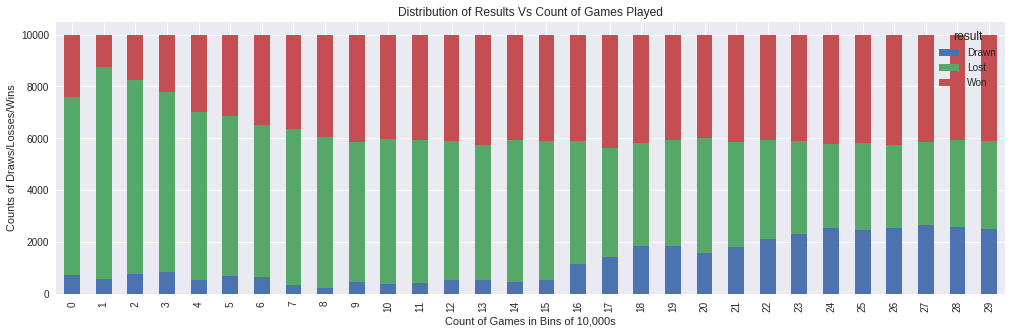

In [ ]:
bins = np.arange(1, game_counter/10000) * 10000
data_for_graph['game_counter_bins'] = np.digitize(data_for_graph["game_counter"], bins, right=True)
counts = data_for_graph.groupby(['game_counter_bins', 'result']).game_counter.count().unstack()
ax=counts.plot(kind='bar', stacked=True,figsize=(17,5))
ax.set_xlabel("Count of Games in Bins of 10,000s")
ax.set_ylabel("Counts of Draws/Losses/Wins")
ax.set_title('Distribution of Results Vs Count of Games Played')

#### Observations:
* It can be observed in the above graph, that as the Program played more and more games against the opponent, its win rate increased and its loss rate reduced
* Due to the noisy nature of the training, I would not be able to provide more specific observations, since the above graph is going to look different each time this kernel is run

### Saving the model

In [ ]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
!pip install keras
from keras.models import load_model
model = load_model('my_model.h5')

## Evaluating the Program

The best way to evaluate the program would be to play tic-tac-toe games against it.

When I played the games against it, it played okay, though it is prone to mistakes.

If you would like to see a few games I played with it,  when using an older version of this code, it is available here:

https://dhanushkishore.github.io/a_self_learning_tic-tac-toe_player/#Evaluating-the-Program

If you would like to try it yourself, I have set up the game below. To play, you would need to fork this kernel, go to edit mode, uncomment the below code and run it.


In [ ]:
model = load_model('my_model.h5')
print("___________________________________________________________________")
print("Welcome to the Tic Tac Toe Game")
print("You will be playing against the self learned Program")
print("When it is your move, enter the coordinates in the form rownumber,columnnumber")
print(" For example, to place 0 at the top right corner, enter 0,2")
print("___________________________________________________________________")

play_again="Y"
while(play_again=="Y"):
    print("___________________________________________________________________")
    print("Starting a new Game")
    game=tic_tac_toe_game()
    game.toss()
    print(game.board)
    print(game.turn_monitor," has won the toss")

    while(1):
        if game.game_status()=="In Progress" and game.turn_monitor==0:
            print("Your Turn")
            while(1):
                try:
                    print('Enter where you would like to place a 0 in the form rownumber,columnnumber: ')
                    instr = input()
                    inList = [int(n) for n in instr.split(',')]
                    coord = tuple(inList)
                    print(coord)
                    game_status,board=game.move(0,coord)
                    print(board)
                    break
                except:
                    print("Invalid Move")
        elif game.game_status()=="In Progress" and game.turn_monitor==1:
            print("Program's turn")
            chosen_move,new_board_state,score=move_selector(model,game.board,game.turn_monitor)
            game_status,board=game.move(game.turn_monitor,chosen_move)
            print(board)
        else:
            break

    if game_status=="Won" and (1-game.turn_monitor)==1:
        print("Program has won")
    if game_status=="Won" and (1-game.turn_monitor)==0:
        print("You has won")
    if game_status=="Drawn":
        print("Game Drawn")
    print("Would you like to play again?Y/N")
    play_again=input()

___________________________________________________________________
Welcome to the Tic Tac Toe Game
You will be playing against the self learned Program
When it is your move, enter the coordinates in the form rownumber,columnnumber
 For example, to place 0 at the top right corner, enter 0,2
___________________________________________________________________
___________________________________________________________________
Starting a new Game
[[2 2 2]
 [2 2 2]
 [2 2 2]]
1  has won the toss
Program's turn
[[2 2 2]
 [2 1 2]
 [2 2 2]]
Your Turn
Enter where you would like to place a 0 in the form rownumber,columnnumber: 
Invalid Move
Enter where you would like to place a 0 in the form rownumber,columnnumber: 
Invalid Move
Enter where you would like to place a 0 in the form rownumber,columnnumber: 
Invalid Move
Enter where you would like to place a 0 in the form rownumber,columnnumber: 
Invalid Move
Enter where you would like to place a 0 in the form rownumber,columnnumber: 
Invalid Move
E

## Next Steps

* Try using a deeper neural network, and trying different learning rates, to see if it improves the results
* Figure out if the Opponent (and training experience) being used currently can be improved
* Increase the number of games being played

## References

Tom M. Mitchell (1997). Machine Learning  (2013 ed.). McGraw-Hill Education ([link](http://www.cs.cmu.edu/afs/cs.cmu.edu/user/mitchell/ftp/mlbook.html))

#### If you found this kernel useful, do please remember to give it an upvote :)